In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import json
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,GroupKFold
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

import os
#print(os.listdir("../input"))

# 데이터 불러오기

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.index = train['id']
test.index = test['id']
print(train.shape, test.shape)
train.head()

(3000, 23) (4398, 22)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,,
1,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
2,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
3,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
4,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
5,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


### data info
- data 수 : train 3000, test 4398

### columns
- id : index
- belongs_to_collection : 시리즈에 속하면 json{ id, name, poster_path, backdrop_path}
- budget : 예산
- genres : 장르 json {id, name}
- homepage : url
- imdb_id : imdb id
- original_language : 언어. (ex : 'en')
- original_title : 자국어 제목
- overview : 요약설명
- popularity : 인기도
- poster_path : 포스터 이미지 url
- production_companies : 제작사 json{name, id}
- production_countries : 제작국가 json{'iso_3166_1'=국가코드, name=국가이름}
- release_date: 개봉일 dd/mm/yy
- runtime : 상영시간 000.0분 
- spoken_languages : 언어 json{iso_639_1 = 국가코드, name = 언어이름}
- status : 개봉 상태
- tagline : 슬로건? 한줄요약? 
- title : 제목
- Keywords : 키워드 json{id, name}
- cast : 캐스팅 정보 json{cast_id, character,credit_id ,gender, id, name , order, profile_path} 
- crew : 스텝 정보 json{credit_id, department, gender, id, job, name, profile_path } 

### target
- revenue : 수입

In [3]:
print(train.shape)
print(test.shape)
print(train.info())
print(train.isna().sum())

(3000, 23)
(4398, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object

# 데이터 살펴보기

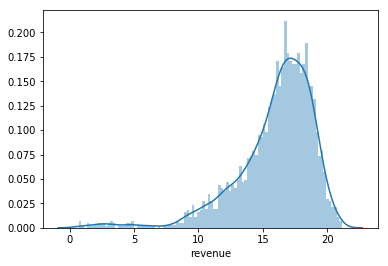

In [4]:
# 수입 살펴보기
# log : x=0 -> y=-Inf -> 경고발생 vs log1p : x=x+1 를 해줌. x=0+1 -> y=0
_ = sns.distplot(np.log1p(train['revenue']), bins=100, kde=True)

train null or 0 : 812
test null or 0: 1211
중앙값 : 22531334.11


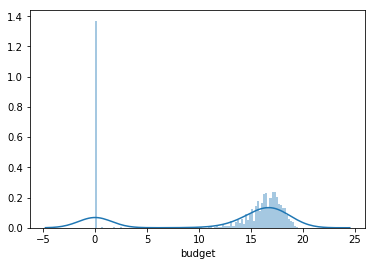

In [5]:
# 예산 살펴보기
print('train null or 0 :',train[train.budget == 0 | train.budget.isnull()].shape[0])
print('test null or 0:', test[test.budget == 0| test.budget.isnull()].shape[0])
print('중앙값 :', train['budget'].mean())
_ = sns.distplot(np.log1p(train['budget']), bins=100, kde=True)

null or 0 : 12
null or 0 : 9
중앙값 :  107.85657104736491


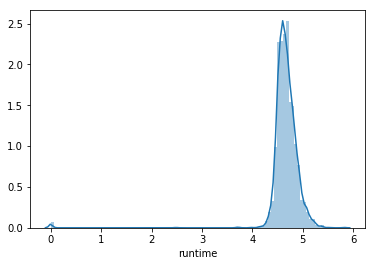

In [6]:
# runtime
print('null or 0 :', train['runtime'][(train['runtime'].isnull()) | (train['runtime']==0)].count())
print('null or 0 :', test['runtime'][(test['runtime'].isnull()) | (test['runtime']==0)].count())
print('중앙값 : ',train['runtime'].mean())
_ = sns.distplot(np.log1p(train['runtime']), bins=100, kde=True)

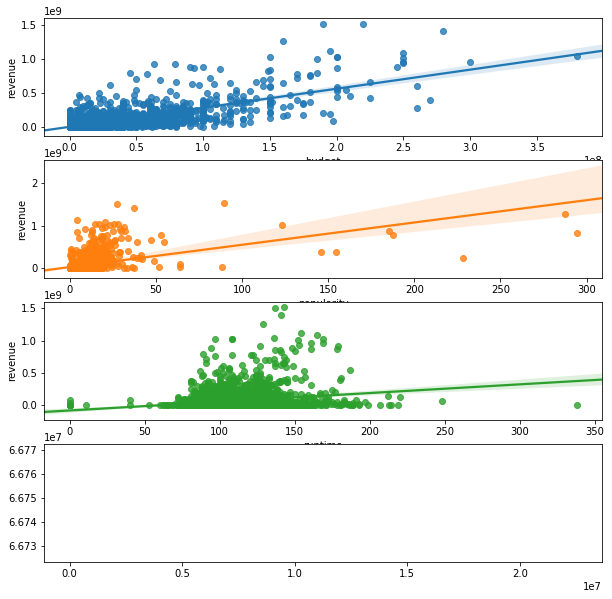

In [7]:
f, axes = plt.subplots(4, 1, figsize=(10, 10))
_ = sns.regplot(x='budget', y='revenue', data=train,ax=axes[0])
_ = sns.regplot(x='popularity', y='revenue', data=train, ax=axes[1])
_ = sns.regplot(x='runtime', y='revenue', data=train, ax=axes[2])

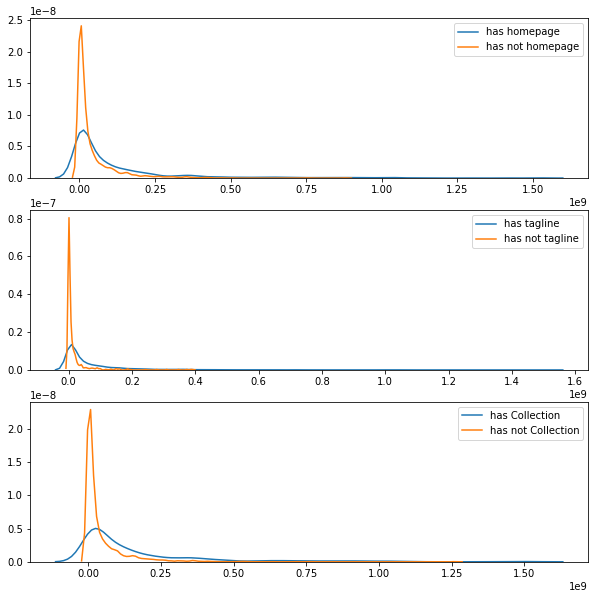

In [8]:
# hp, tagline, collection 유무(null 갯수가 많은 컬럼들) vs revenue
f, axes = plt.subplots(3, 1, figsize=(10, 10))
_ = sns.kdeplot(train['revenue'][(train['homepage'].notnull())],label = 'has homepage', ax = axes[0])
_ = sns.kdeplot(train['revenue'][(train['homepage'].isnull())], label = 'has not homepage',ax = axes[0])
_ = sns.kdeplot(train['revenue'][(train['tagline'].notnull())], label = 'has tagline',ax = axes[1])
_ = sns.kdeplot(train['revenue'][(train['tagline'].isnull())], label = 'has not tagline',ax = axes[1])
_ = sns.kdeplot(train['revenue'][(train['belongs_to_collection'].notnull())], label = 'has Collection',ax = axes[2])
_ = sns.kdeplot(train['revenue'][(train['belongs_to_collection'].isnull())], label = 'has not Collection',ax = axes[2])

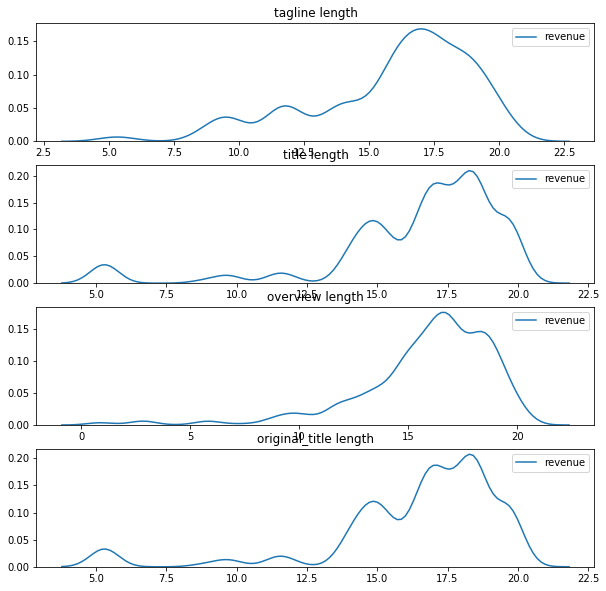

In [9]:
# 단어 길이 vs revenue
f, axes = plt.subplots(4, 1, figsize=(10, 10))
_ = sns.kdeplot(np.log1p(train['revenue'][train['tagline'].str.len()]), ax=axes[0]).set_title('tagline length')
_ = sns.kdeplot(np.log1p(train['revenue'][train['title'].str.len()]), ax=axes[1]).set_title('title length')
_ = sns.kdeplot(np.log1p(train['revenue'][train['overview'].str.len()]), ax=axes[2]).set_title('overview length')
_ = sns.kdeplot(np.log1p(train['revenue'][train['original_title'].str.len()]), ax=axes[3]).set_title('original_title length')

In [10]:
# 개봉 날짜
train['release_date'] = pd.to_datetime(train['release_date'], dayfirst=True)
train['release_year'] = train['release_date'].dt.year
train['release_month'] = train['release_date'].dt.month
train['release_day'] = train['release_date'].dt.day
train['release_dayofweek'] = train['release_date'].dt.dayofweek
train['release_quarter'] = train['release_date'].dt.quarter

In [11]:
# 개봉 년도 이상값 확인
train['release_year'].groupby(train['release_year'][train['release_year']>2010]).count()

release_year
2011.0    124
2012.0    125
2013.0    141
2014.0    123
2015.0    128
2016.0    125
2017.0     40
2021.0      1
2024.0      1
2025.0      2
2026.0      1
2027.0      2
2028.0      3
2030.0      1
2031.0      2
2032.0      3
2033.0      2
2035.0      1
2036.0      4
2038.0      1
2039.0      4
2040.0      2
2042.0      3
2043.0      2
2044.0      2
2045.0      4
2047.0      2
2048.0      6
2049.0      2
2050.0      2
2051.0      4
2052.0      1
2053.0      6
2054.0      6
2055.0      7
2056.0      4
2057.0      3
2058.0      3
2059.0      5
2060.0      8
2061.0      4
2062.0      5
2063.0      5
2064.0      6
2065.0      4
2066.0      7
2067.0      8
2068.0      7
Name: release_year, dtype: int64

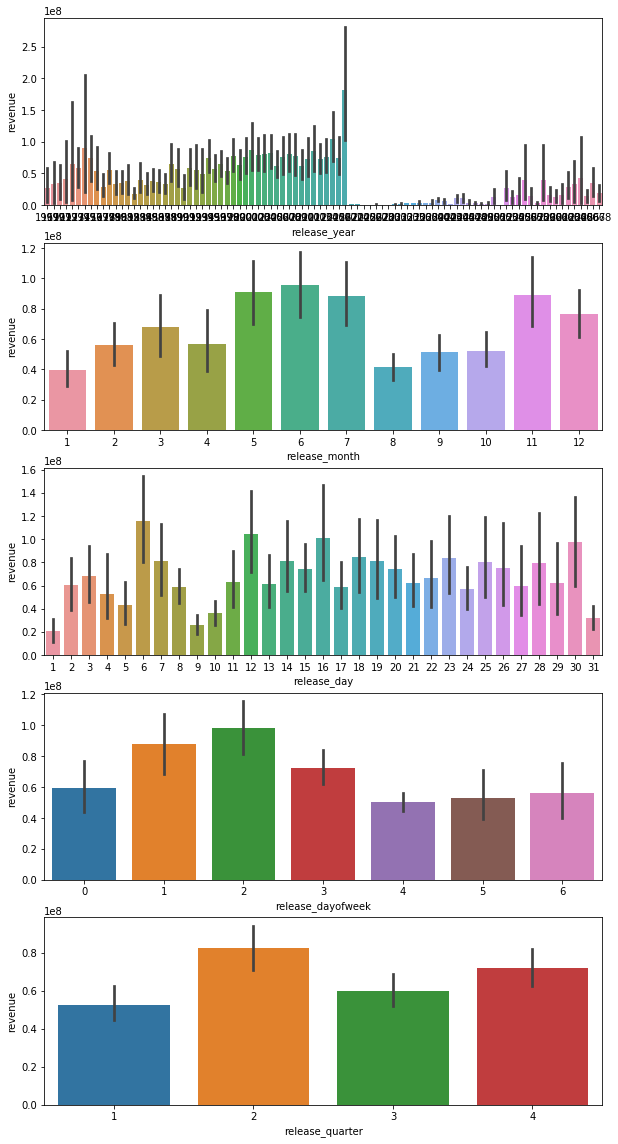

In [12]:
# 개봉 연도, 월, 날짜, 요일, 분기 vs revenue
f, axes = plt.subplots(5, 1, figsize=(10, 20))
_ =sns.barplot(x='release_year', y='revenue',data=train,ax = axes[0])
_ =sns.barplot(x='release_month', y='revenue',data=train,ax = axes[1])
_ =sns.barplot(x='release_day', y='revenue',data=train,ax = axes[2])
_ =sns.barplot(x='release_dayofweek', y='revenue',data=train,ax = axes[3])
_ =sns.barplot(x='release_quarter', y='revenue',data=train,ax = axes[4])

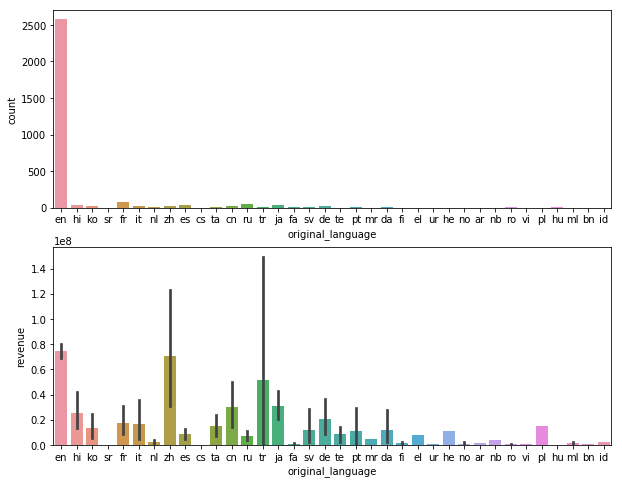

In [13]:
# original language
f, axes = plt.subplots(2, 1, figsize=(10, 8))
_= sns.countplot(x='original_language', data=train, ax=axes[0])
_= sns.barplot(x='original_language', y='revenue',data=train, ax=axes[1])

In [14]:
# json을 dictionary 형태로 변환 
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']
def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else eval(x) ) # eval?
    return df

In [18]:
 import copy
temp = copy.deepcopy(train)
temp = text_to_dict(temp)

In [19]:
# 시리즈별 갯수
# x[0] = train.iloc[0]['belongs_to_collection'][0]
temp['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0).value_counts()[:10]

0                                         2396
James Bond Collection                       16
Friday the 13th Collection                   7
The Pink Panther (Original) Collection       6
Pokémon Collection                           5
Police Academy Collection                    5
Transformers Collection                      4
Ice Age Collection                           4
Rocky Collection                             4
Child's Play Collection                      4
Name: belongs_to_collection, dtype: int64

In [20]:
# 장르별 갯수
temp['genres'].apply(lambda x: x[0]['name'] if x != {} else 0).value_counts()[:10]

Drama          785
Comedy         604
Action         520
Adventure      187
Horror         170
Crime          147
Thriller       116
Animation       76
Documentary     71
Fantasy         68
Name: genres, dtype: int64

# 데이터 가공

In [21]:
# Feature engineering
runtime_mean = train['runtime'].mean()
budget_mean =train['budget'].mean()

def prepare(df):    
    # 0 or null 값 채우기
    df['runtime'][(df['runtime'].isnull()) | (df['runtime'] == 0)] = runtime_mean
    df['budget'][df['budget']==0] = budget_mean

    # 바이너리(유무) 컬럼 치환
    df['hasHP']=0
    df.loc[df['homepage'].isnull() == False, 'hasHP'] = 1
    df['hasTL']=0
    df.loc[df['tagline'].isnull() == False, 'hasTL'] = 1
    df['hasCollection']=0
    df.loc[df['belongs_to_collection'].isnull() == False, 'hasCollection'] = 1
    df['isEng']=0
    df.loc[df['original_language'] == 'en', 'isEng'] = 1    
    df['isReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isReleased"] = 0 

    # 글자 길이 치환
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    df['title_word_count'] = df['title'].str.split().str.len()
    df['original_title_word_count'] = df['original_title'].str.split().str.len()

    # 날짜
    df['release_date'] = pd.to_datetime(df['release_date'], dayfirst=True)
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_day'] = df['release_date'].dt.day    
    df['release_year'][df['release_year']>2018] = df['release_year']-100

    df['release_dayofweek'] = df['release_date'].dt.dayofweek
    df['release_quarter'] = df['release_date'].dt.quarter
    
    # 스케일링
    df['budget'] = np.log1p(df['budget'])
    
    # 범주형 데이터
    df = pd.get_dummies(df, columns=['original_language'], prefix='original_language')
    
    # json 컬럼 변환     
    df = text_to_dict(df)
    
    # 시리즈
    df['_collection_name'] = df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
    le = LabelEncoder()
    le.fit(list(df['_collection_name'].fillna('')))
    df['_collection_name'] = le.transform(df['_collection_name'].fillna('').astype(str))      
    
    # 장르 : 2개 이상인 경우도 있지만 일단 심플하게 첫번째 장르만 집계
    df['_genres_name'] = df['genres'].apply(lambda x: x[0]['name'] if x != {} else 0)
    le = LabelEncoder()
    le.fit(list(df['_genres_name'].fillna('')))
    df['_genres_name'] = le.transform(df['_genres_name'].fillna('').astype(str))  
    
    # 키워드 수, 캐스팅 수
    df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)
    
    # 제작국가 수, 제작사 수
    df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
    df['cast_count'] = df['cast'].apply(lambda x : len(x))
    df['crew_count'] = df['crew'].apply(lambda x : len(x))
    
    df = df.drop(['imdb_id','poster_path','status','homepage','tagline','belongs_to_collection',\
                          'genres', 'production_companies','production_countries', 'spoken_languages',\
                          'Keywords', 'cast', 'crew','overview','title','original_title','release_date'],axis=1)
    
    return df

In [22]:
all_data = pd.concat([train, test]).reset_index(drop = True)
all_data = prepare(all_data)
train = all_data.loc[:train.shape[0] - 1,:]
test = all_data.loc[train.shape[0]:,:] 

print(train.shape)
train.head()

(3000, 71)


,budget,id,popularity,release_day,release_dayofweek,release_month,release_quarter,release_year,revenue,runtime,hasHP,hasTL,hasCollection,isEng,isReleased,overview_word_count,tagline_word_count,title_word_count,original_title_word_count,original_language_af,original_language_ar,original_language_bm,original_language_bn,original_language_ca,original_language_cn,original_language_cs,original_language_da,original_language_de,original_language_el,original_language_en,original_language_es,original_language_fa,original_language_fi,original_language_fr,original_language_he,original_language_hi,original_language_hu,original_language_id,original_language_is,original_language_it,original_language_ja,original_language_ka,original_language_kn,original_language_ko,original_language_ml,original_language_mr,original_language_nb,original_language_nl,original_language_no,original_language_pl,original_language_pt,original_language_ro,original_language_ru,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_th,original_language_tr,original_language_ur,original_language_vi,original_language_xx,original_language_zh,_collection_name,_genres_name,_num_Keywords,_num_cast,production_countries_count,production_companies_count,cast_count,crew_count
0,16.454568,1,6.575393,20.0,4.0,2.0,1.0,2015.0,12314651.0,93.0,0,1,1,1,1,29.0,11.0,5.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,282,4,4,24,1,3,24,72
1,17.504390,2,8.248895,8.0,1.0,6.0,2.0,2004.0,95149435.0,113.0,0,1,1,1,1,69.0,13.0,6.0,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,641,4,4,20,1,1,20,9
2,15.009433,3,64.299990,10.0,4.0,10.0,4.0,2014.0,13092000.0,105.0,1,1,0,1,1,21.0,10.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,12,51,1,3,51,64
3,13.997833,4,3.174936,3.0,0.0,9.0,3.0,2012.0,16000000.0,122.0,1,0,0,0,1,106.0,NaN,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,18,7,7,1,0,7,3
4,16.930418,5,1.148070,2.0,5.0,5.0,2.0,2009.0,3923970.0,118.0,0,0,0,0,1,32.0,NaN,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,4,1,0,4,2


# 모델 생성

In [23]:
features = list(train.columns)
features =  [i for i in features if i != 'id' and i != 'revenue']

In [24]:
# for mse validation 
def score(data, y):
    validation_res = pd.DataFrame({"id": data["id"].values,
                                   "transactionrevenue": data["revenue"].values,
                                   "predictedrevenue": np.expm1(y)})
    validation_res = validation_res.groupby("id")["transactionrevenue", "predictedrevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionrevenue"].values), 
                                     np.log1p(validation_res["predictedrevenue"].values)))

In [25]:
class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['id'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['id'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['id'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 500, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["revenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["revenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

In [26]:
Kfolder = KFoldValidation(train)

In [27]:
lgbmodel = lgb.LGBMRegressor(n_estimators=10000, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 5,
                             num_leaves=30, 
                             min_child_samples=100,
                             learning_rate=0.01,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.9,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             bagging_seed=42, 
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)
Kfolder.validate(train, test, features , lgbmodel, name="lgbfinal", prepare_stacking=True) 

Fold  0 :
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.46681
[200]	valid_0's rmse: 2.291
[300]	valid_0's rmse: 2.23293
[400]	valid_0's rmse: 2.20664
[500]	valid_0's rmse: 2.19516
[600]	valid_0's rmse: 2.18953
[700]	valid_0's rmse: 2.18263
[800]	valid_0's rmse: 2.17858
[900]	valid_0's rmse: 2.17894
[1000]	valid_0's rmse: 2.18131
[1100]	valid_0's rmse: 2.18387
[1200]	valid_0's rmse: 2.18767
[1300]	valid_0's rmse: 2.19074
Early stopping, best iteration is:
[881]	valid_0's rmse: 2.17805
Fold  0  error:  2.178045994936804
Fold  0  score:  2.178045994936804
Fold  1 :
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.15662
[200]	valid_0's rmse: 2.0037
[300]	valid_0's rmse: 1.96648
[400]	valid_0's rmse: 1.95566
[500]	valid_0's rmse: 1.95362
[600]	valid_0's rmse: 1.95233
[700]	valid_0's rmse: 1.94941
[800]	valid_0's rmse: 1.95175
[900]	valid_0's rmse: 1.95482
[1000]	valid_0's rmse: 1.95398
[1100]	valid_0's rmse: 1.95

2.0421236611721

In [28]:
xgbmodel = xgb.XGBRegressor(max_depth=5, 
                            learning_rate=0.01, 
                            n_estimators=10000, 
                            objective='reg:linear', 
                            gamma=1.45, 
                            seed=42, 
                            silent=True,
                            subsample=0.8, 
                            colsample_bytree=0.7, 
                            colsample_bylevel=0.5)
Kfolder.validate(train, test, features, xgbmodel, name="xgbfinal", prepare_stacking=True)

Fold  0 :
[0]	validation_0-rmse:15.5559
Will train until validation_0-rmse hasn't improved in 500 rounds.
[100]	validation_0-rmse:6.06973
[200]	validation_0-rmse:3.03699
[300]	validation_0-rmse:2.3399
[400]	validation_0-rmse:2.22658
[500]	validation_0-rmse:2.20224
[600]	validation_0-rmse:2.19096
[700]	validation_0-rmse:2.18454
[800]	validation_0-rmse:2.18229
[900]	validation_0-rmse:2.18158
[1000]	validation_0-rmse:2.1794
[1100]	validation_0-rmse:2.17962
[1200]	validation_0-rmse:2.17909
[1300]	validation_0-rmse:2.18002
[1400]	validation_0-rmse:2.1815
[1500]	validation_0-rmse:2.18198
[1600]	validation_0-rmse:2.18332
[1700]	validation_0-rmse:2.18503
Stopping. Best iteration:
[1234]	validation_0-rmse:2.17784

Fold  0  error:  2.1778374118742474
Fold  0  score:  2.1778374118742474
Fold  1 :
[0]	validation_0-rmse:15.5644
Will train until validation_0-rmse hasn't improved in 500 rounds.
[100]	validation_0-rmse:6.13147
[200]	validation_0-rmse:2.99685
[300]	validation_0-rmse:2.16735
[400]	valid

2.0425948176889173

In [29]:
catmodel = cat.CatBoostRegressor(iterations=10000, 
                                 learning_rate=0.01, 
                                 depth=5, 
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200,
                                 random_seed=42)
Kfolder.validate(train, test, features , catmodel, name="catfinal", prepare_stacking=True,
               fit_params={"use_best_model": True, "verbose": 100})

Fold  0 :
0:	learn: 16.1100419	test: 16.0442591	best: 16.0442591 (0)	total: 55.5ms	remaining: 9m 15s
100:	learn: 6.4854985	test: 6.4603565	best: 6.4603565 (100)	total: 734ms	remaining: 1m 11s
200:	learn: 3.2945835	test: 3.3317065	best: 3.3317065 (200)	total: 1.4s	remaining: 1m 8s
300:	learn: 2.4210679	test: 2.5375693	best: 2.5375693 (300)	total: 2.07s	remaining: 1m 6s
400:	learn: 2.1769063	test: 2.3665360	best: 2.3665360 (400)	total: 2.73s	remaining: 1m 5s
500:	learn: 2.0852843	test: 2.3245757	best: 2.3245757 (500)	total: 3.42s	remaining: 1m 4s
600:	learn: 2.0361552	test: 2.3023857	best: 2.3023857 (600)	total: 4.14s	remaining: 1m 4s
700:	learn: 2.0014223	test: 2.2864935	best: 2.2864935 (700)	total: 4.82s	remaining: 1m 3s
800:	learn: 1.9713770	test: 2.2723298	best: 2.2723297 (799)	total: 5.51s	remaining: 1m 3s
900:	learn: 1.9477746	test: 2.2623186	best: 2.2622237 (898)	total: 6.17s	remaining: 1m 2s
1000:	learn: 1.9235317	test: 2.2522777	best: 2.2522682 (999)	total: 6.83s	remaining: 1m 1

800:	learn: 2.0577789	test: 2.0357756	best: 2.0348179 (786)	total: 5.32s	remaining: 1m 1s
900:	learn: 2.0327877	test: 2.0326715	best: 2.0315952 (892)	total: 5.96s	remaining: 1m
1000:	learn: 2.0120829	test: 2.0271752	best: 2.0271752 (1000)	total: 6.61s	remaining: 59.4s
1100:	learn: 1.9883818	test: 2.0221035	best: 2.0219576 (1097)	total: 7.3s	remaining: 59s
1200:	learn: 1.9719629	test: 2.0202571	best: 2.0200085 (1192)	total: 7.96s	remaining: 58.4s
1300:	learn: 1.9568894	test: 2.0174547	best: 2.0174547 (1300)	total: 8.62s	remaining: 57.7s
1400:	learn: 1.9402159	test: 2.0128189	best: 2.0127683 (1398)	total: 9.29s	remaining: 57s
1500:	learn: 1.9289045	test: 2.0115857	best: 2.0112059 (1484)	total: 9.96s	remaining: 56.4s
1600:	learn: 1.9218964	test: 2.0117153	best: 2.0109159 (1528)	total: 10.6s	remaining: 55.7s
1700:	learn: 1.9137313	test: 2.0123328	best: 2.0109159 (1528)	total: 11.3s	remaining: 55s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 2.010915888
bestIteration =

600:	learn: 2.0279436	test: 2.4002764	best: 2.4002764 (600)	total: 4.23s	remaining: 1m 6s
700:	learn: 1.9892096	test: 2.3693133	best: 2.3693133 (700)	total: 4.92s	remaining: 1m 5s
800:	learn: 1.9642831	test: 2.3494369	best: 2.3494369 (800)	total: 5.63s	remaining: 1m 4s
900:	learn: 1.9407374	test: 2.3333151	best: 2.3333151 (900)	total: 6.3s	remaining: 1m 3s
1000:	learn: 1.9208806	test: 2.3195841	best: 2.3195841 (1000)	total: 6.99s	remaining: 1m 2s
1100:	learn: 1.9035521	test: 2.3093306	best: 2.3093306 (1100)	total: 7.64s	remaining: 1m 1s
1200:	learn: 1.8835421	test: 2.3017201	best: 2.3017201 (1200)	total: 8.32s	remaining: 1m
1300:	learn: 1.8687921	test: 2.2975007	best: 2.2974189 (1296)	total: 9.03s	remaining: 1m
1400:	learn: 1.8544951	test: 2.2944109	best: 2.2941089 (1394)	total: 9.71s	remaining: 59.6s
1500:	learn: 1.8441534	test: 2.2923424	best: 2.2923424 (1500)	total: 10.4s	remaining: 58.8s
1600:	learn: 1.8336778	test: 2.2898590	best: 2.2898560 (1598)	total: 11.1s	remaining: 58.1s
170

2.058674516445456

In [30]:
train['Revenue_lgb'] = train["lgbfinal"]
print("RMSE model lgb :" ,score(train, train.Revenue_lgb),)

train['Revenue_xgb'] = train["xgbfinal"]
print("RMSE model xgb :" ,score(train, train.Revenue_xgb))

train['Revenue_cat'] = train["catfinal"]
print("RMSE model cat :" ,score(train, train.Revenue_cat))

# 모델 합성
train['Revenue_Dragon'] = 0.4 * train["lgbfinal"] + 0.2 * train["xgbfinal"] + 0.4 * train["catfinal"]
print("RMSE model Dragon :" ,score(train, train.Revenue_Dragon))

RMSE model lgb : 2.050008984403589
RMSE model xgb : 2.049187671826457
RMSE model cat : 2.064719463970163
RMSE model Dragon : 2.0362918867996305


In [31]:
test['revenue'] =  np.expm1(test["lgbfinal"])
test[['id','revenue']].to_csv('submission_lgb.csv', index=False)
print(test[['id','revenue']].head())

test['revenue'] =  np.expm1(test["xgbfinal"])
test[['id','revenue']].to_csv('submission_xgb.csv', index=False)
print(test[['id','revenue']].head())

test['revenue'] =  np.expm1(test["catfinal"])
test[['id','revenue']].to_csv('submission_cat.csv', index=False)
print(test[['id','revenue']].head())

test['revenue'] =  np.expm1(0.4 * test["lgbfinal"]+ 0.4 * test["catfinal"] + 0.2 * test["xgbfinal"])
test[['id','revenue']].to_csv('submission_Dragon1.csv', index=False)
print(test[['id','revenue']].head())

        id       revenue
3000  3001  1.887667e+06
3001  3002  1.706377e+06
3002  3003  8.645051e+06
3003  3004  4.739656e+06
3004  3005  7.429749e+05
        id       revenue
3000  3001  3.152043e+06
3001  3002  1.289659e+06
3002  3003  7.966129e+06
3003  3004  5.273486e+06
3004  3005  4.169569e+05
        id       revenue
3000  3001  3.279060e+06
3001  3002  9.528790e+05
3002  3003  5.757084e+06
3003  3004  8.043288e+06
3004  3005  5.600829e+05
        id       revenue
3000  3001  2.608485e+06
3001  3002  1.278027e+06
3002  3003  7.228323e+06
3003  3004  5.982624e+06
3004  3005  5.911651e+05


# 참고
- https://www.kaggle.com/zero92/tmdb-prediction
- https://www.kaggle.com/somang1418/eda-lgb-xgb-modelings-with-a-cute-panda-meme
